In [58]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import os
import re
import random

import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import albumentations as A

# Set random seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


In [59]:
def random_padding(img, **kwargs):
    if img.dtype != np.uint8:
        if img.max() <= 1.1:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)

    max_pad=10
    fill_value = (255, 255, 255)

    pad_left = np.random.randint(0, max_pad + 1)
    pad_right = np.random.randint(0, max_pad + 1)
    pad_top = np.random.randint(0, max_pad // 2 + 1)
    pad_bottom = np.random.randint(0, max_pad // 2 + 1)

    return cv2.copyMakeBorder(
        img,
        pad_top,
        pad_bottom,
        pad_left,
        pad_right,
        cv2.BORDER_CONSTANT,
        value=fill_value
    )



transform = A.Compose([
    A.PadIfNeeded(min_height=48, min_width=48, fill=255, p=1.0),

    A.Affine(
        scale={"x": (0.8, 1.2), "y": (0.9, 1.1)},
        rotate=(-2, 2),
        shear=(-2, 2),
        fit_output=True,
        border_mode=cv2.BORDER_CONSTANT,
        fill=255,
        fill_mask=255,
        p=0.7
    ),

    A.Lambda(image=random_padding, p=0.7),

    A.Perspective(
        scale=(0.005, 0.03),
        keep_size=True,
        fit_output=True,
        border_mode=cv2.BORDER_CONSTANT,
        fill=(255, 255, 255),
        fill_mask=(255, 255, 255),
        p=0.5
    ),

    A.GaussianBlur(
        sigma_limit=(0.3, 1.0), 
        blur_limit=(1, 3), 
        p=0.5
    ),

    A.GaussNoise(
        std_range=(0.005, 0.05), 
        p=0.5
    ),

    A.RandomBrightnessContrast(
        brightness_limit=(-0.2, 0.2),
        contrast_limit=(-0.2, 0.2),
        ensure_safe_range=True,
        p=0.5
    ),
], seed=SEED)


In [60]:
def augment_synthetic_dataset(
    csv_path: str,
    img_dir: str,
    save_img_dir: str,
    save_csv_path: str,
    transform,
    aug_per_image: int = 2,
):
    os.makedirs(save_img_dir, exist_ok=True)
    if os.listdir(save_img_dir):
        raise RuntimeError("save_img_dir is not empty")

    df = pd.read_csv(csv_path)
    augmented_rows = []

    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row["image"])

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue
        image_np = np.array(image)

        for i in range(aug_per_image):
            aug = transform(image=image_np)
            aug_img_np = aug["image"]
            assert aug_img_np.ndim == 3 and aug_img_np.shape[2] == 3

            aug_img = Image.fromarray(aug_img_np)

            aug_name = f"{os.path.splitext(row['image'])[0]}_aug{i+1}.png"
            aug_img.save(os.path.join(save_img_dir, aug_name))

            aug_row = row.to_dict()
            aug_row["image"] = aug_name
            augmented_rows.append(aug_row)

    df_aug = pd.DataFrame(augmented_rows)
    df_aug.to_csv(save_csv_path, index=False)

    print(f"Augmented images saved to: {save_img_dir}")
    print(f"Augmented CSV saved to: {save_csv_path}")
    print(f"Total augmented images: {len(df_aug)}")



AUG_PER_IMAGE = 2
BASE_DATA_DIR = "data/word_nglegena_synthetic_20260109_223615"

augment_synthetic_dataset(
    csv_path=f"{BASE_DATA_DIR}/label_train.csv",
    img_dir=f"{BASE_DATA_DIR}/image_train",
    save_img_dir=f"{BASE_DATA_DIR}/image_train_aug",
    save_csv_path=f"{BASE_DATA_DIR}/label_train_aug.csv",
    transform=transform,
    aug_per_image=AUG_PER_IMAGE,
)


Augmented images saved to: data/word_nglegena_synthetic_20260109_223615/image_train_aug
Augmented CSV saved to: data/word_nglegena_synthetic_20260109_223615/label_train_aug.csv
Total augmented images: 2000


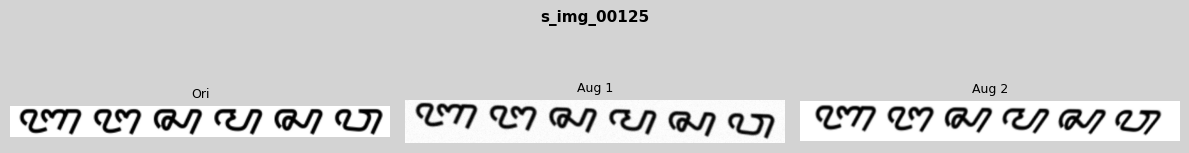

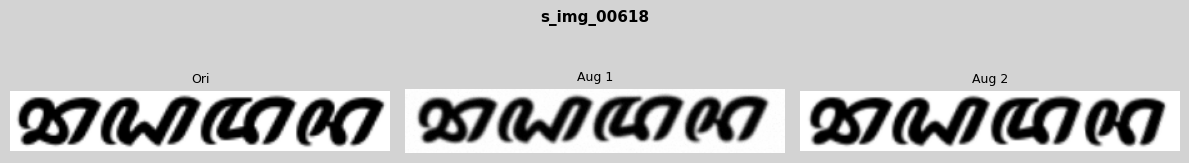

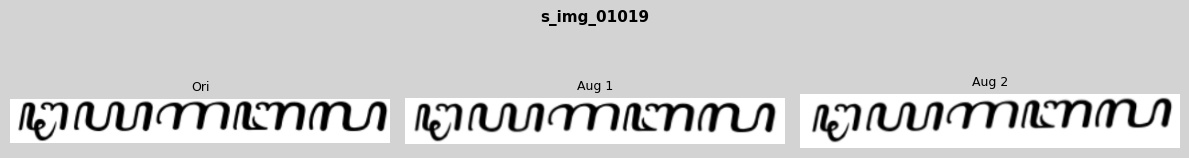

In [61]:
def visualize_augmentations(
    csv_ori,
    dir_ori,
    csv_aug,
    dir_aug,
    n_samples=5,
    max_aug=6,
):
    df_ori = pd.read_csv(csv_ori)
    df_aug = pd.read_csv(csv_aug)

    samples = df_ori.sample(n=min(n_samples, len(df_ori)), random_state=SEED)

    for _, row in samples.iterrows():
        base = row["image"].replace(".png", "")

        imgs = [Image.open(os.path.join(dir_ori, row["image"])).convert("L")]
        titles = ["Ori"]

        aug_rows = df_aug[df_aug["image"].str.startswith(base + "_aug")]
        for i, fname in enumerate(aug_rows["image"][:max_aug], 1):
            imgs.append(Image.open(os.path.join(dir_aug, fname)).convert("L"))
            titles.append(f"Aug {i}")

        fig, axes = plt.subplots(1, len(imgs), figsize=(4 * len(imgs), 2), facecolor="lightgray")
        if len(imgs) == 1:
            axes = [axes]

        for ax, img, title in zip(axes, imgs, titles):
            ax.imshow(img, cmap="gray")
            ax.set_title(title, fontsize=9)
            ax.axis("off")

        plt.suptitle(base, fontsize=11, fontweight="bold")
        plt.tight_layout()
        plt.show()



BASE_DATA_DIR = "data/word_nglegena_synthetic_20260109_223615"
visualize_augmentations(
    csv_ori=f"{BASE_DATA_DIR}/label_train.csv",
    dir_ori=f"{BASE_DATA_DIR}/image_train",
    csv_aug=f"{BASE_DATA_DIR}/label_train_aug.csv",
    dir_aug=f"{BASE_DATA_DIR}/image_train_aug",
    n_samples=3,
    max_aug=6,
)


In [62]:
# def morph_gradient(img, **kwargs):
#     if img.ndim == 3:
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
#     grad = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)

#     return cv2.addWeighted(img, 0.85, grad, 0.15, 0)


# def skeletonize(img, **kwargs):
#     if img.ndim == 3:
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#     _, bin_img = cv2.threshold(
#         img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
#     )

#     skel = np.zeros(bin_img.shape, np.uint8)
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#     temp = bin_img.copy()

#     while True:
#         eroded = cv2.erode(temp, kernel)
#         opened = cv2.dilate(eroded, kernel)
#         skel |= cv2.subtract(temp, opened)
#         temp = eroded.copy()
#         if cv2.countNonZero(temp) == 0:
#             break

#     return cv2.bitwise_not(skel)


# def thinning(img, **kwargs):
#     if img.ndim == 3:
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#     return cv2.dilate(img, kernel, iterations=2)


# def thickening(img, **kwargs):
#     if img.ndim == 3:
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
#     return cv2.erode(img, kernel, iterations=2)


# def local_occlusion(img, max_patches=60, patch_size=12, fill=255, **kwargs):
#     h, w = img.shape[:2]
#     out = img.copy()

#     for _ in range(np.random.randint(1, max_patches + 1)):
#         x = np.random.randint(0, max(1, w - patch_size))
#         y = np.random.randint(0, max(1, h - patch_size))
#         out[y:y+patch_size, x:x+patch_size] = fill

#     return out


# def random_padding(img, max_pad=60, **kwargs):
#     if len(img.shape) == 3:
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     if img.dtype != np.uint8:
#         if img.max() <= 1.1:
#             img = (img * 255).astype(np.uint8)
#         else:
#             img = img.astype(np.uint8)

#     fill_value = 255 

#     pad_left = np.random.randint(0, max_pad + 1)
#     pad_right = np.random.randint(0, max_pad + 1)
#     pad_top = np.random.randint(0, max_pad // 2 + 1)
#     pad_bottom = np.random.randint(0, max_pad // 2 + 1)

#     return cv2.copyMakeBorder(
#         img,
#         pad_top,
#         pad_bottom,
#         pad_left,
#         pad_right,
#         cv2.BORDER_CONSTANT,
#         value=fill_value
#     )


# augments = [
#     ("original", A.NoOp(p=1.0)),

#     ("Padding", A.Lambda(image=random_padding, p=1.0)),

#     ("Scale", A.Affine(scale={"x": (0.3, 2.0), "y": (0.3, 2.0)}, keep_ratio=True, fit_output=False, border_mode=cv2.BORDER_CONSTANT, fill=255, p=1.0)),
#     ("Rotate", A.Affine(rotate=(-30, 30), scale=1.0, fit_output=False, border_mode=cv2.BORDER_CONSTANT, fill=255, p=1.0)),
#     ("Shear", A.Affine(shear=(-25, 25), fit_output=False, border_mode=cv2.BORDER_CONSTANT, fill=255, p=1.0)),
#     ("Perspective", A.Perspective(scale=(0.15,0.25), p=1.0, fill=255)),

#     ("Contrast", A.RandomBrightnessContrast(brightness_limit=(-1.0, 1.0), contrast_limit=(-1.0, 1.0), p=1.0)),
#     ("Gamma", A.RandomGamma(gamma_limit=(40, 160), p=1.0)),

#     ("Elastic", A.ElasticTransform(alpha=128, sigma=8, border_mode=cv2.BORDER_CONSTANT, fill=255, p=1.0)),
#     ("Grid Distortion", A.GridDistortion(num_steps=5, distort_limit=0.3, border_mode=cv2.BORDER_CONSTANT, fill=255, p=1.0)),

#     ("Morph Gradient", A.Lambda(image=morph_gradient, p=1.0)),
#     ("Skeletonization", A.Lambda(image=skeletonize, p=1.0)),
#     ("Thinning", A.Lambda(image=thinning, p=1.0)),
#     ("Thickening", A.Lambda(image=thickening, p=1.0)),

#     ("Gaussian Blur", A.GaussianBlur(blur_limit=9, p=1.0)),
#     ("Motion Blur", A.MotionBlur(blur_limit=9, p=1.0)),

#     ("Gauss Noise", A.GaussNoise(std_range=(0.5, 0.9), p=1.0)),
#     ("ISO Noise", A.Compose([A.ToRGB(p=1.0), A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5)), A.ToGray(p=1.0)])),
#     ("Local Occlusion", A.Lambda(image=local_occlusion, p=1.0)),
# ]

# IMG_DIR = "./data/word_nglegena_20260102_155715/image"
# img = cv2.imread(f"{IMG_DIR}/{np.random.choice(os.listdir(IMG_DIR))}", cv2.IMREAD_GRAYSCALE)
# assert img is not None, "Gagal membaca gambar"

# images = []
# titles = []

# for name, aug in augments:
#     out = aug(image=img)
#     images.append(out["image"])
#     titles.append(name)

# import math
# cols = 3
# rows = math.ceil(len(images) / cols)

# plt.figure(figsize=(cols * 4, rows * 1.5), facecolor="gray")

# for i, (im, title) in enumerate(zip(images, titles)):
#     plt.subplot(rows, cols, i + 1)
#     plt.imshow(im, cmap="gray")
#     plt.title(title, fontsize=10)
#     plt.axis("off")

# plt.tight_layout()
# plt.show()
